# Import Necessary Libraries

In [1]:
import torch
import numpy as np
import tqdm
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchtext
import math
import matplotlib.pyplot as plt
from PIL import Image
import math
import torch.nn as nn
from torch.nn import functional as F
from mingpt.utils import CfgNode as CN
import time
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore") 
torch.cuda.empty_cache()

# Global Variables

In [2]:
csv_path_train = '../All_Data/annotations_train.csv'
image_path_train = '../All_Data/train'
csv_path_valid = '../All_Data/annotations_valid.csv'
image_path_valid = '../All_Data/valid'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 8
epochs = 50
n_embed = 100
glove = torchtext.vocab.GloVe(name="6B",dim=n_embed) # embedding size = 100  
torch.manual_seed(42)
np.random.seed(42)

# Prepare Dataset

In [3]:
class Custom_Dataset(Dataset):
    def __init__(self, image_folder_path, vocab, csv_path, custom_transforms):
        self.image_folder_path = image_folder_path
        annotations = pd.read_csv(csv_path)
        self.captions = np.array(annotations['captions'])
        self.image_names = np.array(annotations['file_directory'])    
        self.custom_transforms = custom_transforms
        self.replace_dict = {'Cockapoo':'parrot', 'Dalmation':'dalmatian', 'Bluetick':'bluebonnet', 'Perenees':'pere', 'Groenendael':'goren', 'Shih-Tzu':'shih', 'Shar_Pei':'shar', 'Komondor':'komon'}
        self.vocab = vocab
        
    def __len__(self):
        return len(self.captions)

    
    def __getitem__(self, idx):
        image_full_name = self.image_folder_path + '/' + self.image_names[idx]
        x = Image.open(image_full_name)
        if self.custom_transforms is not None:
            x = self.custom_transforms(x)
#             x = x.permute(1,2,0)
        ground_truth_cap = self.captions[idx]
        V = len(self.vocab.vectors)
        L = ground_truth_cap.split()
        for i, word in enumerate (L):
            if word in self.replace_dict.keys():
                L[i] = self.replace_dict[word]
                
        tokenized_caption = torch.tensor([self.vocab.stoi.get(w.lower(), V-1) for w in L])  # Use the last word in the vocab as the "out-of-vocabulary" token
        if V-1 in tokenized_caption:
            print('Wrong Labelling')
#         print(image_full_name, ground_truth_cap)        
        return x, tokenized_caption
    
    def get_vocab_size(self):
        return len(self.vocab.vectors)  
    
    def get_block_size(self):
        all_captions_len = []
        for i in range(len(self.captions)):
            all_captions_len.append(len(self.captions[i].split()))
        return max(all_captions_len)+1
    
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.RandomHorizontalFlip(p=0.3),
    torchvision.transforms.RandomRotation(degrees=10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  
    y_input = [item[1][:-1] for item in batch]  
    y_label = [item[1] for item in batch]
    maxlen_input = max([len(s) for s in y_input])
    maxlen_label = max([len(s) for s in y_label])
    padding_value = glove.stoi.get('unk')
    #x from first word to the second last word, y from second word to the last word
    input_cap, label_cap = [], []
    for sy_i, sy_l in zip(y_input, y_label):
        input_cap.append(torch.cat([sy_i, torch.ones(maxlen_input - len(sy_i))*padding_value]))
        label_cap.append(torch.cat([sy_l, torch.ones(maxlen_label - len(sy_l))*padding_value]))
    return torch.stack(x).long().to(device), torch.stack(input_cap).long().to(device), torch.stack(label_cap).long().to(device)
  
train_dataset = Custom_Dataset(image_path_train, glove, csv_path_train, train_transforms)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn = lambda batch: lm_collate_fn(batch, device))

valid_dataset = Custom_Dataset(image_path_valid, glove, csv_path_valid, valid_transforms)
batch_size = 32
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn = lambda batch: lm_collate_fn(batch, device))

vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_block_size()

# Model

In [4]:
#model.py
# -----------------------------------------------------------------------------

class NewGELU(nn.Module):

    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        #x.shape = (batch, sent len, embedding)
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class GPT(nn.Module):
    """ GPT Language Model """

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config, vocab):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size

        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                # names follow the huggingface naming conventions
                # GPT-1
                'openai-gpt':   dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                # GPT-2 configs
                'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
                'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
                'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
                # Gophers
                'gopher-44m':   dict(n_layer=8, n_head=16, n_embd=512),
                # (there are a number more...)
                # I made these tiny models up
                'gpt-mini':     dict(n_layer=5, n_head=5, n_embd=n_embed),
                'gpt-micro':    dict(n_layer=4, n_head=4, n_embd=128),
                'gpt-nano':     dict(n_layer=3, n_head=3, n_embd=48),
            }[config.model_type])

        #wte is embedding for words
        #wpe is embedding for positions
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding.from_pretrained(vocab.vectors, freeze = True),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def configure_optimizers(self, train_config, cnn_model_params):
        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )
        if cnn_model_params is not None:
            # create the pytorch optimizer object
            optim_groups = [
                {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
                {"params": cnn_model_params,'lr': 3e-5}
            ]
            
            n_parameters_transformer = sum(p.numel()
               for p in self.parameters() if p.requires_grad)
            n_parameters_cnn = sum(p.numel()
                           for p in cnn_model_params if p.requires_grad)
            print(f"Number of trainable params: {n_parameters_transformer + n_parameters_cnn}")
        else:
            # create the pytorch optimizer object
            optim_groups = [
                {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
                {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0}
            ]  
        
            n_parameters_transformer = sum(p.numel()
                           for p in self.parameters() if p.requires_grad)
            print(f"Number of trainable params: {n_parameters_transformer}")
        
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, image_embed, idx=None, targets=None, finetune_classify=False):

        device = image_embed.device
  
        if idx is not None:
            b, t = idx.size()
            assert t <= self.block_size, f"Cannot forwarnd sequence of length {t}, block size is only {self.block_size}"
            pos = torch.arange(0, t+1, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

            # forward the GPT model itself
            tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
            tok_emb = torch.cat((image_embed.unsqueeze(1), tok_emb), 1)
          
        else:
            pos = torch.arange(0, 1, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
            tok_emb = image_embed.unsqueeze(1)   
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        
        assert tok_emb[0].shape == pos_emb[0].shape, f"wrong token or position embedding"
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        #x.shape = (batch, sentence len, embedding)
        if not finetune_classify:
            # LM forward procedure
            logits = self.lm_head(x)
        else:
            # Finetune classify procedure
            print('error')
            return
            
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        return logits, loss


In [5]:
# set up model configurations
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = vocab_size
#block_size is a max sentence length in dataset
model_config.block_size = block_size
model = GPT(model_config, glove)

number of parameters: 40.61M


# Trainer

In [6]:
class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 4
        # optimizer parameters
        C.max_iters = None
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1 # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_loader, valid_loader, epochs, downstream_finetune = False):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.epochs = epochs
        self.callbacks = defaultdict(list)
        self.downstream_finetune = False
        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config
        cnn_model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True,)
        for param in cnn_model.parameters():
            param.requires_grad = False
        
        cnn_model.classifier = nn.Sequential(nn.Linear(1280, 512),
                                            nn.ReLU(),
                                            nn.Dropout(0.2),
                                            nn.Linear(512, n_embed))
        cnn_model = cnn_model.to(device)
        # setup the optimizer
        self.optimizer = model.configure_optimizers(config, cnn_model.parameters())
        train_loss_set = []
        valid_loss_set = []
        # setup the dataloader     
        for epoch in range(self.epochs):
            print('Epoch ' + str(epoch) + ':')
            model.train()
            cnn_model.train()
            train_loss_epoch = []
            
            with tqdm.tqdm(total=len(self.train_loader)) as pbar:
                #train model and calculate training loss
                for x, y_input, y_label in self.train_loader:
                    # forward the model
                    x = x.type(torch.FloatTensor).to(device)
                    image_embed = cnn_model(x)
                    logits, self.loss = model(image_embed.to(self.device), y_input, y_label, self.downstream_finetune)
                    train_loss_epoch.append(self.loss.detach().cpu().item())

                    # backprop and update the parameters
                    model.zero_grad(set_to_none=True)
                    self.loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                    self.optimizer.step()
                    pbar.update(1)
                    del x, y_input, y_label

                print('Training Loss is : {}'.format(sum(train_loss_epoch)/len(train_loss_epoch)))
                train_loss_set.append(sum(train_loss_epoch)/len(train_loss_epoch))
            
            print('start_validation')    
            model.eval()
            cnn_model.eval()  
            valid_loss_epoch = []
            for x, y_input, y_label in self.valid_loader:
                # forward the model
                x = x.type(torch.FloatTensor).to(device)
                image_embed = cnn_model(x)
                logits, loss = model(image_embed.to(self.device), y_input, y_label, self.downstream_finetune)
                valid_loss_epoch.append(loss.detach().cpu().item())
                del x, y_input, y_label
                
            current_valid_loss = sum(valid_loss_epoch)/len(valid_loss_epoch)
            print('Validation Loss is : {}'.format(current_valid_loss))              
            
            #save the checkpoint if the current validation loss is better than all previous epochs   
            if len(valid_loss_set) > 0 and current_valid_loss < min(valid_loss_set):
                torch.save(model.state_dict(), './saved_checkpoints/best_transformer.pt')
                torch.save(cnn_model.state_dict(), './saved_checkpoints/best_cnn.pt')
                print('saving checkpoints')
            #stop training if the validation loss increases for two consecutive epochs     
            if len(valid_loss_set) > 2 and current_valid_loss > valid_loss_set[-1] and valid_loss_set[-1] > valid_loss_set[-2]:
                valid_loss_set.append(current_valid_loss)  
                break           
            else:
                valid_loss_set.append(current_valid_loss)
        
        return train_loss_set, valid_loss_set, epoch

In [7]:
#start training
train_config = Trainer.get_default_config()
trainer = Trainer(train_config, model, train_loader, valid_loader, epochs, downstream_finetune = False)

# Train!
train_loss_set, valid_loss_set, epoch = trainer.run()

running on device cuda


Using cache found in C:\Users\zixua/.cache\torch\hub\pytorch_vision_v0.10.0


Number of trainable params: 41315772
Epoch 0:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:22<00:00,  5.48it/s]


Training Loss is : 8.713794231414795
start_validation
Validation Loss is : 5.1838845941755505
Epoch 1:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:19<00:00,  6.42it/s]


Training Loss is : 2.600729073935408
start_validation
Validation Loss is : 1.0569030907418993
saving checkpoints
Epoch 2:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:18<00:00,  6.57it/s]


Training Loss is : 0.7998156591159541
start_validation
Validation Loss is : 0.6961187952094607
saving checkpoints
Epoch 3:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:29<00:00,  4.23it/s]


Training Loss is : 0.607119265126019
start_validation
Validation Loss is : 0.6032332364055846
saving checkpoints
Epoch 4:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:25<00:00,  4.92it/s]


Training Loss is : 0.5388626899661088
start_validation
Validation Loss is : 0.5614820238616731
saving checkpoints
Epoch 5:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:19<00:00,  6.27it/s]


Training Loss is : 0.5067223034253935
start_validation
Validation Loss is : 0.541541596253713
saving checkpoints
Epoch 6:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:19<00:00,  6.27it/s]


Training Loss is : 0.4873194040321722
start_validation
Validation Loss is : 0.5353723929988013
saving checkpoints
Epoch 7:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  5.91it/s]


Training Loss is : 0.47486930189093923
start_validation
Validation Loss is : 0.5227817495663961
saving checkpoints
Epoch 8:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:21<00:00,  5.66it/s]


Training Loss is : 0.4686266937391545
start_validation
Validation Loss is : 0.5182590203152763
saving checkpoints
Epoch 9:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.10it/s]


Training Loss is : 0.4596851836375105
start_validation
Validation Loss is : 0.5211980922354592
Epoch 10:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.10it/s]


Training Loss is : 0.45407295348198434
start_validation
Validation Loss is : 0.5149799635012945
saving checkpoints
Epoch 11:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:19<00:00,  6.22it/s]


Training Loss is : 0.45413658749766467
start_validation
Validation Loss is : 0.5127036621173223
saving checkpoints
Epoch 12:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:19<00:00,  6.21it/s]


Training Loss is : 0.4508289416146472
start_validation
Validation Loss is : 0.5109417024585936
saving checkpoints
Epoch 13:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.08it/s]


Training Loss is : 0.4396481344370338
start_validation
Validation Loss is : 0.5096800790892707
saving checkpoints
Epoch 14:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.11it/s]


Training Loss is : 0.44176979302390806
start_validation
Validation Loss is : 0.5052696433332231
saving checkpoints
Epoch 15:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:19<00:00,  6.27it/s]


Training Loss is : 0.4375094420057002
start_validation
Validation Loss is : 0.5092596842183007
Epoch 16:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  5.94it/s]


Training Loss is : 0.4404128722059048
start_validation
Validation Loss is : 0.5072492758433024
Epoch 17:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  5.97it/s]


Training Loss is : 0.4333066644707346
start_validation
Validation Loss is : 0.5045288569397397
saving checkpoints
Epoch 18:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.10it/s]


Training Loss is : 0.4346936291795436
start_validation
Validation Loss is : 0.5076532479789522
Epoch 19:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.07it/s]


Training Loss is : 0.42962090465111463
start_validation
Validation Loss is : 0.5006386372778151
saving checkpoints
Epoch 20:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.04it/s]


Training Loss is : 0.4297116134709459
start_validation
Validation Loss is : 0.4990292141834895
saving checkpoints
Epoch 21:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.01it/s]


Training Loss is : 0.4302920602201446
start_validation
Validation Loss is : 0.4991511752208074
Epoch 22:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  5.90it/s]


Training Loss is : 0.42423823984657844
start_validation
Validation Loss is : 0.4984959049357308
saving checkpoints
Epoch 23:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.10it/s]


Training Loss is : 0.4279930574622581
start_validation
Validation Loss is : 0.49915242691834766
Epoch 24:


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:20<00:00,  6.15it/s]


Training Loss is : 0.42016021870985265
start_validation
Validation Loss is : 0.5005278471443388


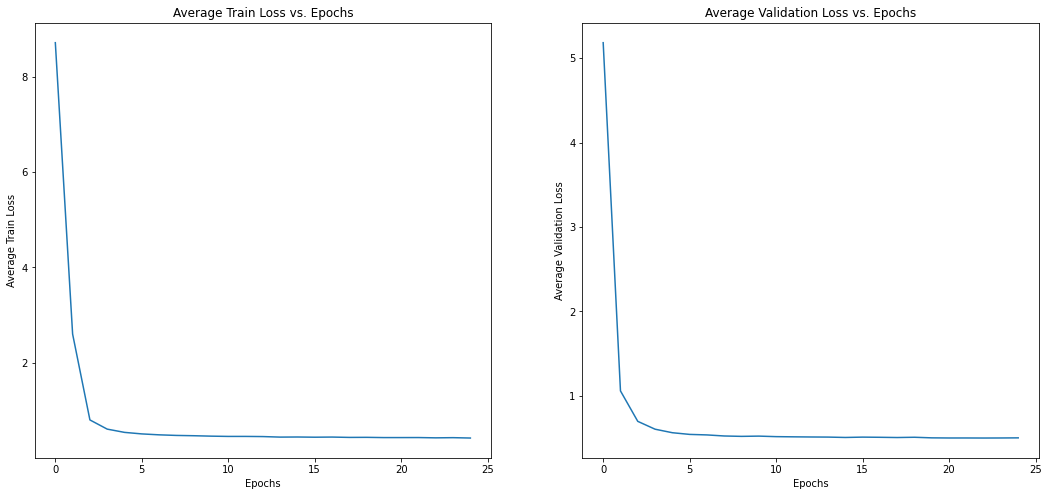

In [8]:
#plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
epoch_values = list(range(0, epoch+1, 1))

ax1.plot(epoch_values, train_loss_set)
ax2.plot(epoch_values, valid_loss_set)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Average Train Loss')    
ax1.set_title('Average Train Loss vs. Epochs')

ax2.set_xlabel('Epochs')
ax2.set_ylabel('Average Validation Loss')    
ax2.set_title('Average Validation Loss vs. Epochs')
plt.show()  